### bd CPS seasonal adjustment

----

Brian Dew, @bd_econ

August 22, 2019

In [1]:
import pandas as pd
import statsmodels.api as sm
import os
os.environ['X13PATH'] = '/home/brian/Documents/x13asall_V1.1_B39/'

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [8]:
from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)

First, let's look at some variables from the bd CPS:

In [2]:
cols = ['MONTH', 'BASICWGT', 'AGE', 'LFS', 'FEMALE', 'MARRIED', 'WBHAO']
pd.read_feather('cps2019.ft', columns=cols).head(10)

,MONTH,BASICWGT,AGE,FEMALE,MARRIED,WBHAO,LFS
0,7,1637.476807,63,1,1,White,Employed
1,7,1649.725464,65,0,1,White,NILF
2,7,1734.040649,80,1,0,White,NILF
3,7,1916.892456,51,1,1,White,Employed
4,7,1811.555542,51,0,1,White,Employed
5,7,0.000000,12,0,0,White,nan
6,7,1586.036499,19,0,0,White,Employed
7,7,2624.587646,49,0,1,Black,Employed
8,7,2028.514648,59,1,0,Black,NILF
9,7,1565.000000,64,0,1,White,NILF


I'd like to look at labor force participation rates for some unpublished subgroups. For example, unmarried white or black women age 25-54. 

In [3]:
lfpr = lambda x: 1 - (x.loc[x['LFS'] == 'NILF', 'BASICWGT'].sum() / x.BASICWGT.sum())
wb = ['White', 'Black']

In [4]:
d = {}
for year in range(1989, 2020):
    df = (pd.read_feather(f'cps{year}.ft', columns=cols)
            .query('25 <= AGE <=54 and MARRIED == 0 and WBHAO in @wb'))
    res = df.groupby('MONTH').apply(lfpr)
    for month, rate in res.iteritems():
        d[f'{year}-{str(month).zfill(2)}-01'] = rate

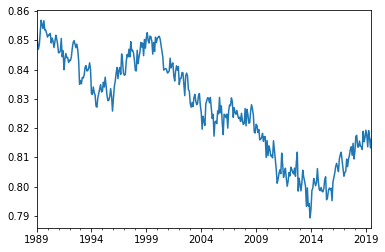

In [5]:
%matplotlib inline
data = pd.Series(d, index=pd.to_datetime(list(d.keys())))
data.plot()

There seems to be a cyclical component that has picked up since 2014. To isolate trends, particularly in recent months, one option is to apply a moving average. 

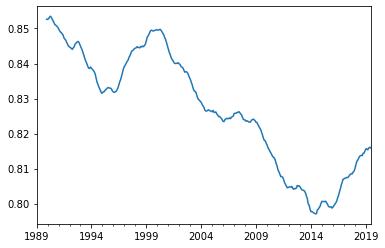

In [6]:
data.rolling(12).mean().plot()

Because the latest data in the moving average represents only 1/12th of the latest datapoint, and I am interested in the latest datapoint having more weight, another option is to apply seasonal adjustment.

In [9]:


sm = x13_arima_analysis(data)

CalledProcessError: Command '/home/brian/Documents/x13asall_V1.1_B39/x13as' died with <Signals.SIGSEGV: 11>.

In [11]:
import pandas as pd
import pytest

from statsmodels.datasets import macrodata, co2
from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)

x13path = _find_x12()

pytestmark = pytest.mark.skipif(x13path is False,
                                reason='X13/X12 not available')

dta = macrodata.load_pandas().data
index = pd.period_range(start='1959Q1', end='2009Q3', freq='Q')
dta.index = index
quarterly_data = dta.dropna()

dta = co2.load_pandas().data
dta['co2'] = dta.co2.interpolate()
monthly_data = dta.resample('M')
# change in pandas 0.18 resample is deferred object
if not isinstance(monthly_data, (pd.DataFrame, pd.Series)):
    monthly_data = monthly_data.mean()

monthly_start_data = dta.resample('MS')
if not isinstance(monthly_start_data, (pd.DataFrame, pd.Series)):
    monthly_start_data = monthly_start_data.mean()

data = (monthly_data, monthly_start_data, monthly_data.co2,
        monthly_start_data.co2, quarterly_data.realgdp,
        quarterly_data[['realgdp']])
ids = ('monthly', 'monthly_start', 'monthly_co2', 'monthly_start_co2',
       'series', 'dataframe')


@pytest.fixture(params=data, ids=ids)
def dataset(request):
    return request.param


def test_x13_arima_select_order(dataset):
    res = x13_arima_select_order(dataset)
    assert isinstance(res.order, tuple)
    assert isinstance(res.sorder, tuple)


@pytest.mark.matplotlib
def test_x13_arima_plot(dataset):
    res = x13_arima_analysis(dataset)
    res.plot()

CalledProcessError: Command '/home/brian/Documents/x13asall_V1.1_B39/x13as' died with <Signals.SIGSEGV: 11>.

In [ ]:
for month, rate in res.iteritems():
    d[f'{year}-{month}-01'] = rate

In [ ]:
pd.to_datetime(list(d.keys()))

In [ ]:
columns = ['MONTH', 'BASICWGT', 'LFS', 'WBHAO', 'AGE', 'FEMALE', 'MARRIED']
wb = ['White', 'Black']

In [ ]:
df = (pd.read_feather('cps1998.ft', columns=columns)
        .query('25 <= AGE <=54 and FEMALE == 1 and MARRIED == 1 and WBHAO in @wb'))

In [ ]:
round((1 - (df.groupby('LFS').BASICWGT.sum() / df.BASICWGT.sum()).NILF) * 100, 1)